# Title

## Introduction

This project focuses on assisting a computer science research group at The University of British Columbia that is looking into player behaviour in video games. Specifically, the research involves a Minecraft server which tracks player movements and actions and how they interact with the world. 

The research group need to target their recruitment efforts to make sure they have enough resources and have enough players to get an ample amount of data. They want to answer the research question: *Which types of players are most likely to contribute significant amounts of data?*

Answering this question is crucial to helping the research group optimize their recruitment. Therefore, by leveraging data science and machine learning techniques, this project aims to predict those player engagement patterns.

### Data
The data comes in two different datasets, the players data and the sessions data. Below are full data descriptions of both datasets. 

#### Players Data
The players dataset has 9 variables with 196 observations. It captures user information on for the minecraft server.

- experience: A ordinal categorical variable that describes the user's experience level with Minecraft. The categories range from - "Beginner", "Amateur", "Regular", "Pro", "Veteran".
- subscribe: A logical data variable, which is either TRUE, FALSE or NA. In this case, there is only TRUE or FALSE. This variable represents if the player is subscribed to the servers email updates.
- hashedEmail: A string variable of a hashed representation of the email the player used to sign up with.
- played_hours: A numeric variable detailing the total hours a user has spent on the server.
- name: A string variable representing the first name of the player.
- gender: a string variable representing the players gender.
- age: A numeric variable representing the players age.
- individualId: The variable is empty throughout the entire dataset but appears to be just a unique identifier for the player.
- organizationName: The variable is empty throughout the entire dataset but appears to be capture the organization which the player is associated with.

#### Sessions Data
The players dataset has 5 variables with 1535 observations. It captures video game session information for a player. It is linked to the player through the hashedEmail thus the two tables could be combined into one dataset to give more information.

Variables
- hashedEmail: A string variable representing the hashed email of a player.
- start_time: A string variable representing the start time of the session in the format of DD/MM/YYYY HH:MM
- end_time: A string variable representing the end time of the session in the format of DD/MM/YYYY HH:MM
- original_start_time: A numerical variable representing the start time of the session in UNIX timestamp format (number of seconds since January 1, 1970 (UTC)).
- original_end_time: A numerical variable representing the end time of the session in UNIX timestamp format (number of seconds since January 1, 1970 (UTC)).

In [1]:
library(tidyverse)
library(ggplot2)
library(repr)
library(readr)  
library(dplyr)
library(nnet)
library(caret)
library(tidymodels)
library(GGally)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conf

## Downloading Data

In [2]:
players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
players <- read.csv(players_url)
sessions <- read.csv(sessions_url)

In [3]:
head(players)

,experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>,<lgl>,<lgl>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


In [4]:
head(sessions)

,hashedEmail,start_time,end_time,original_start_time,original_end_time
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
2,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
3,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
4,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
5,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
6,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [107]:
players_selected <- players |>
select(-individualId, -organizationName, -name, -hashedEmail)
head(players_selected)

,experience,subscribe,played_hours,gender,age
,<chr>,<lgl>,<dbl>,<chr>,<int>
1,Pro,TRUE,30.3,Male,9
2,Veteran,TRUE,3.8,Male,17
3,Veteran,FALSE,0.0,Male,17
4,Amateur,TRUE,0.7,Female,21
5,Regular,TRUE,0.1,Male,21
6,Amateur,TRUE,0.0,Female,17


In [130]:
players_selected <- players_selected |>
    mutate(subscribe = as_factor(subscribe))

players_final <- players_selected |>
    drop_na()

head(players_final)

,experience,subscribe,played_hours,gender,age
,<fct>,<fct>,<dbl>,<chr>,<int>
1,Pro,1,30.3,Male,9
2,Veteran,1,3.8,Male,17
3,Veteran,0,0.0,Male,17
4,Amateur,1,0.7,Female,21
5,Regular,1,0.1,Male,21
6,Amateur,1,0.0,Female,17


In [131]:
players_final_count <- players_selected |>
  group_by(experience) |>
  mutate(count = n()) |>
  ungroup()
head(players_final_count)

experience,subscribe,played_hours,gender,age,count
<fct>,<fct>,<dbl>,<chr>,<int>,<int>
Pro,1,30.3,Male,9,14
Veteran,1,3.8,Male,17,48
Veteran,0,0.0,Male,17,48
Amateur,1,0.7,Female,21,63
Regular,1,0.1,Male,21,36
Amateur,1,0.0,Female,17,63


In [132]:
players_summary <- players_selected |>
  group_by(experience) |>
  summarise(
    avg_played_hours = mean(played_hours, na.rm = TRUE),
    avg_age = mean(age, na.rm = TRUE),
    subscribe_rate = mean(subscribe, na.rm = TRUE),
    gender_categories = paste(names(table(gender)), table(gender), sep = ":", collapse = ","),
    count = n(),
    .groups = "drop")
head(players_summary)


Warning message:
“There were 5 warnings in `summarise()`.
The first warning was:
ℹ In argument: `subscribe_rate = mean(subscribe, na.rm = TRUE)`.
ℹ In group 1: `experience = Pro`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
ℹ Run `dplyr::last_dplyr_warnings()` to see the 4 remaining warnings.”


experience,avg_played_hours,avg_age,subscribe_rate,gender_categories,count
<fct>,<dbl>,<dbl>,<dbl>,<chr>,<int>
Pro,2.6000000,22.21429,NA,"Male:11,Non-binary:2,Other:1",14
Veteran,0.6479167,20.95833,NA,"Agender:2,Female:5,Male:31,Non-binary:8,Prefer not to say:2",48
Amateur,6.0174603,20.25397,NA,"Female:14,Male:40,Non-binary:1,Prefer not to say:4,Two-Spirited:4",63
Regular,18.2083333,22.77778,NA,"Female:4,Male:26,Non-binary:3,Prefer not to say:2,Two-Spirited:1",36
Beginner,1.2485714,21.65714,NA,"Female:14,Male:16,Non-binary:1,Prefer not to say:3,Two-Spirited:1",35


In [133]:
players_gender <- players_summary
    experience = c("Pro", "Veteran", "Amateur", "Regular", "Beginner")
    gender_categories = c("Male:11,Non-binary:2,Other:1", 
                        "Agender:2,Female:5,Male:31,Non-binary:8,Prefer not to say:2",
                        "Female:14,Male:40,Non-binary:1,Prefer not to say:4,Two-Spirited:4",
                        "Female:4,Male:26,Non-binary:3,Prefer not to say:2,Two-Spirited:1",
                        "Female:14,Male:16,Non-binary:1,Prefer not to say:3,Two-Spirited:1")
    stringsAsFactors = FALSE

players_gender_final <- players_gender |>
    separate_rows(gender_categories, sep = ",") |>
    separate(gender_categories, into = c("gender", "count"), sep = ":") |>
    mutate(count = as.numeric(count))

players_one_hot <- players_gender_final |>
    pivot_wider(names_from = gender, values_from = count, values_fill = list(count = 0))

players_final_one_hot <- players_one_hot |>
    group_by(experience) |>
    summarise(across(everything(), sum, na.rm = TRUE))

players_final_sum <- players_final_one_hot |>
    rowwise() |>
    mutate(total_gender_count = sum(c(Male, `Non-binary`, Other, Agender, Female, `Prefer not to say`, `Two-Spirited`), na.rm = TRUE)) |>
    ungroup()

players_final_sum

experience,avg_played_hours,avg_age,subscribe_rate,Male,Non-binary,Other,Agender,Female,Prefer not to say,Two-Spirited,total_gender_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pro,2.6000000,22.21429,0,11,2,1,0,0,0,0,14
Veteran,0.6479167,20.95833,0,31,8,0,2,5,2,0,48
Amateur,6.0174603,20.25397,0,40,1,0,0,14,4,4,63
Regular,18.2083333,22.77778,0,26,3,0,0,4,2,1,36
Beginner,1.2485714,21.65714,0,16,1,0,0,14,3,1,35


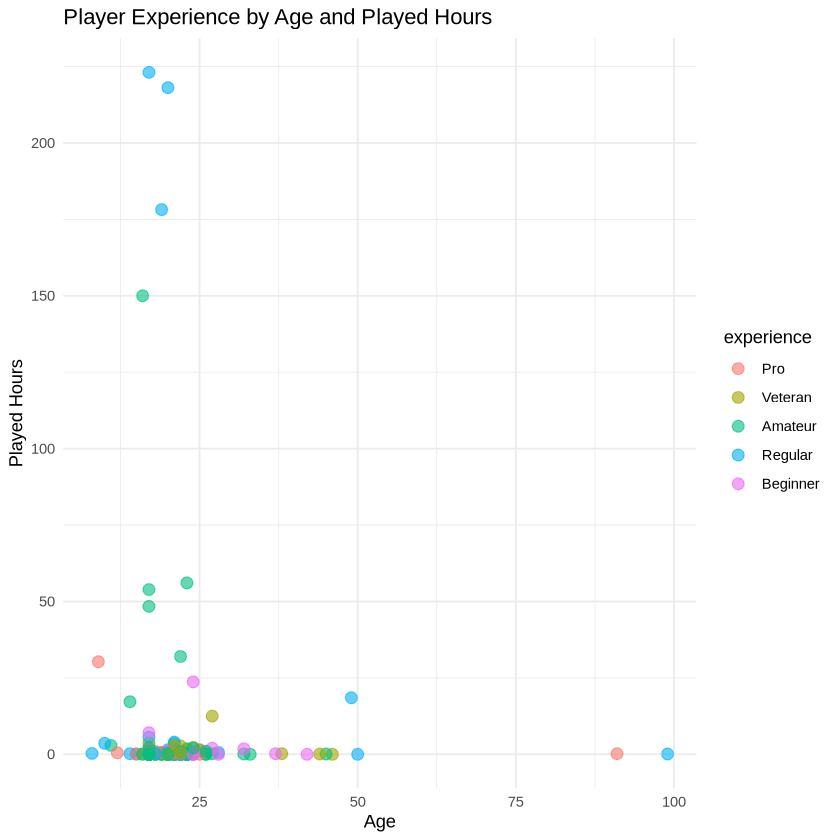

In [134]:
ggplot(players_final_count, aes(x = age, y = played_hours, color = experience)) +
    geom_point(size = 3, alpha = 0.6) +
    labs(title = "Player Experience by Age and Played Hours",
         x = "Age",
         y = "Played Hours") +
    theme_minimal() 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


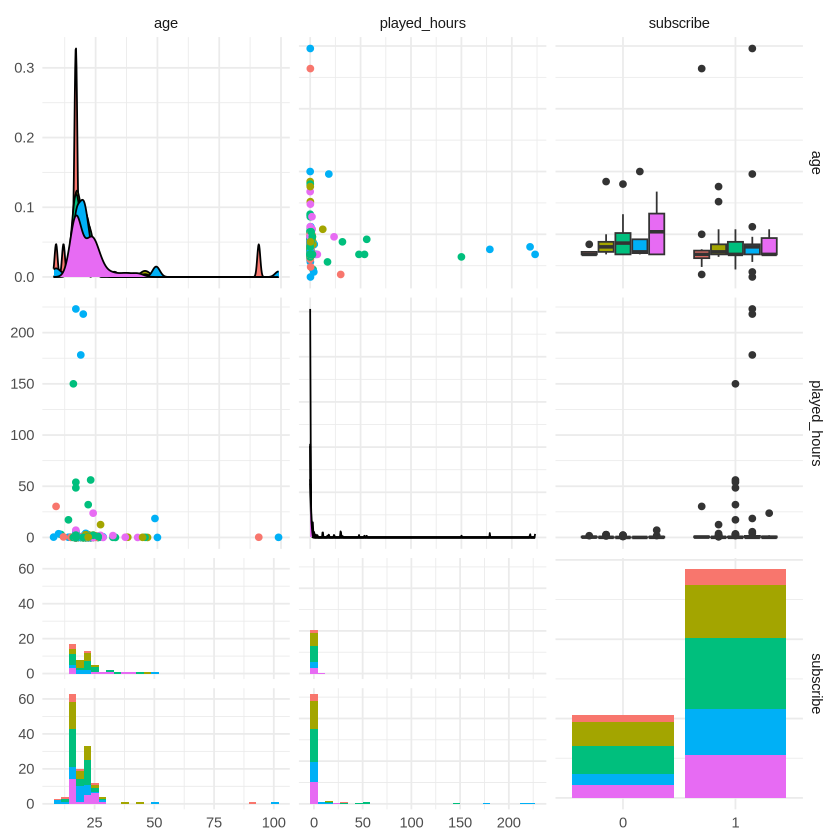

In [135]:
ggpairs(players_final, 
        columns = c("age", "played_hours", "subscribe"),
        aes(color = experience),
        upper = list(continuous = "points"),
        lower = list(continuous = "points")) +
        theme_minimal()


In [136]:
players_final_transformed <- players_final |>
    mutate(played_hours_log = log(played_hours + 1))
head(players_final_transformed)

,experience,subscribe,played_hours,gender,age,played_hours_log
,<fct>,<fct>,<dbl>,<chr>,<int>,<dbl>
1,Pro,1,30.3,Male,9,3.44361810
2,Veteran,1,3.8,Male,17,1.56861592
3,Veteran,0,0.0,Male,17,0.00000000
4,Amateur,1,0.7,Female,21,0.53062825
5,Regular,1,0.1,Male,21,0.09531018
6,Amateur,1,0.0,Female,17,0.00000000


In [137]:
players_split <- initial_split(players_final_transformed, prop = 0.80, strata = experience)
players_train <- training(players_split)
players_test <- testing(players_split)
glimpse(players_train)

Rows: 155
Columns: 6
$ experience       <fct> Amateur, Amateur, Amateur, Pro, Amateur, Amateur, Ama…
$ subscribe        <fct> 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,…
$ played_hours     <dbl> 0.7, 0.0, 0.1, 0.0, 0.0, 48.4, 0.5, 0.7, 1.8, 0.1, 0.…
$ gender           <chr> "Female", "Male", "Male", "Male", "Male", "Female", "…
$ age              <int> 21, 21, 17, 17, 22, 17, 17, 21, 23, 23, 17, 33, 17, 1…
$ played_hours_log <dbl> 0.53062825, 0.00000000, 0.09531018, 0.00000000, 0.000…


In [138]:
players_proportions <- players_train |>
                      group_by(experience) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(players_train))

players_proportions

experience,n,percent
<fct>,<int>,<dbl>
Pro,13,8.387097
Veteran,38,24.516129
Amateur,49,31.612903
Regular,28,18.064516
Beginner,27,17.419355


In [139]:
players_recipe <- recipe(subscribe ~ age + played_hours_log + subscribe + gender + experience, data = players_train) |>
  step_scale(all_numeric_predictors()) |>
  step_center(all_numeric_predictors()) |>
  step_dummy(all_nominal_predictors()) |>
  step_novel(all_nominal_predictors())

In [140]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
  set_mode("classification") |>
  set_engine("kknn") 
knn_fit <- workflow()|>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
4 Recipe Steps

• step_scale()
• step_center()
• step_dummy()
• step_novel()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2580645
Best kernel: rectangular
Best k: 5

In [143]:
validation_predicted <- predict(knn_fit, players_test) |>
    bind_cols(players_test)
head(validation_predicted)

.pred_class,experience,subscribe,played_hours,gender,age,played_hours_log
<fct>,<fct>,<fct>,<dbl>,<chr>,<int>,<dbl>
1,Veteran,1,3.8,Male,17,1.56861592
1,Amateur,1,0.0,Female,17,0.00000000
1,Beginner,1,1.5,Female,25,0.91629073
1,Amateur,1,0.2,Male,22,0.18232156
1,Amateur,0,0.1,Female,17,0.09531018
1,Beginner,1,0.0,Male,17,0.00000000


In [144]:
accuracy_result <- validation_predicted |>
  accuracy(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")
accuracy_result

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7804878


In [146]:
precision_result <- validation_predicted |>
    precision(truth = subscribe, estimate = .pred_class)
precision_result

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.6666667


In [147]:
recall_result <- validation_predicted |>
  recall(truth = subscribe, estimate = .pred_class)
recall_result

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.3636364


In [149]:
confusion_matrix_result <- validation_predicted |>
  conf_mat(truth = subscribe, estimate = .pred_class)
confusion_matrix_result

          Truth
Prediction  0  1
         0  4  2
         1  7 28